In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [2]:
def std_data(RR):
    if RR == 0:
        path_train = "D:\PHD\Research\Data\RemoveRR\sim_5000_0_90_140_train_NoRR.npy"
        path_test = "D:\PHD\Research\Data\RemoveRR\sim_3000_0_141_178_test_NoRR.npy"
    elif RR == 1:
        path_train = "D:\PHD\Research\Data\RemoveRR\sim_5000_0_90_140_train_RR.npy"
        path_test = "D:\PHD\Research\Data\RemoveRR\sim_3000_0_141_178_test_RR.npy"

    data_train = np.load(path_train)
    data_test = np.load(path_test)
    signals_train_l, labels_train_l = data_train[:, :1000], data_train[:, 1000:]
    signals_test_l, labels_test_l = data_test[:, :1000], data_test[:, 1000:]

    signals_l_train_ls = []
    labels_l_train_ls = []
    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)
    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [3]:
# peaks detection from Yida
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, duration, sampling_rate, dis):
    max = np.max(data_tmp)
    data_tmp = data_tmp / max

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal)

    t_peaks = t[peak_indices]
    peak_values = signal[peak_indices]
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=dis)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2


In [4]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

In [5]:
def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    data_tmp_raw = data_tmp

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)

    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)

    features = np.array([ m_12/m_21, mag_0/mag_1])

    return features

(4687, 1000) (2853, 6)
(4687, 1000) (2853, 6)


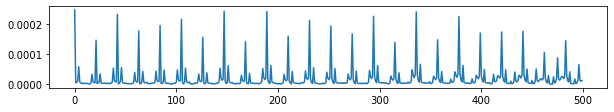

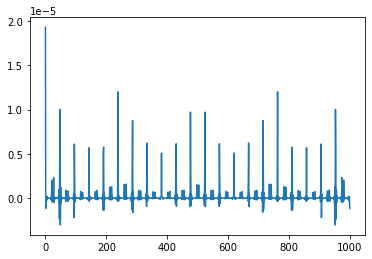

In [28]:
# from tqdm import tqdm
from sklearn.decomposition import FastICA

from Code.Tutorial.decompose import eemd_decomposition, vmd_decomposition
if __name__=='__main__':
    labels_train_NoRR, labels_test_NoRR, signals_train_NoRR, signals_test_NoRR = std_data(0)
    labels_train_RR, labels_test_RR, signals_train_RR, signals_test_RR = std_data(1)
    signal = signals_train_RR[0]

    sample_rate = 100
    fft1 = np.fft.fft(signal)

    n = len(signal)
    # 计算频率轴
    freq = np.fft.fftfreq(n, d=1 / sample_rate)

    # 仅保留正半轴的频谱
    positive_freq_indices = np.where(freq >= 0)
    positive_freq = freq[positive_freq_indices]
    positive_fft1 = np.abs(fft1[positive_freq_indices])
    plt.figure(figsize=(10, 1.5))
    # plt.plot(positive_freq, positive_fft1)
    plt.plot(positive_fft1)
    #
    # u_25 = vmd_decomposition(fft1, K=2, alpha=25, tau=0, DC=0, init=1, tol=1e-7, show=True)
    # # u_20 = vmd_decomposition(positive_fft1, K=2, alpha=20, tau=0, DC=0, init=1, tol=1e-7, show=False)
    # plt.plot(u_25[0, :])
    # ffilt = np.fft.ifft(u_25[0, :])  # Compute the inverse FFT
    # ffilt = ffilt.real  # Take the real part of the inverse FFT
    ffilt = np.fft.ifft(np.abs(fft1))  # Compute the inverse FFT
    ffilt = ffilt.real  # Take the real part of the inverse FFT
    plt.show()
    plt.plot(ffilt)